# Natural and artificial perturbations

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import solar_system_ephemeris

from poliastro.twobody.propagation import propagate, cowell
from poliastro.ephem import build_ephem_interpolant
from poliastro.core.elements import rv2coe

from poliastro.constants import rho0_earth, H0_earth
from poliastro.core.perturbations import atmospheric_drag_exponential, third_body, J2_perturbation
from poliastro.bodies import Earth, Moon
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter3D

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

### Atmospheric drag ###
The poliastro package now has several commonly used natural perturbations. One of them is atmospheric drag! See how one can monitor decay of the near-Earth orbit over time using our new module poliastro.twobody.perturbations!

In [3]:
R = Earth.R.to(u.km).value
k = Earth.k.to(u.km ** 3 / u.s ** 2).value

orbit = Orbit.circular(Earth, 250 * u.km, epoch=Time(0.0, format="jd", scale="tdb"))

# parameters of a body
C_D = 2.2  # dimentionless (any value would do)
A_over_m = ((np.pi / 4.0) * (u.m ** 2) / (100 * u.kg)).to_value(u.km ** 2 / u.kg)  # km^2/kg
B = C_D * A_over_m

# parameters of the atmosphere
rho0 = rho0_earth.to(u.kg / u.km ** 3).value  # kg/km^3
H0 = H0_earth.to(u.km).value

tofs = TimeDelta(np.linspace(0 * u.h, 100000 * u.s, num=2000))

rr = propagate(
    orbit,
    tofs,
    method=cowell,
    ad=atmospheric_drag_exponential,
    R=R,
    C_D=C_D,
    A_over_m=A_over_m,
    H0=H0,
    rho0=rho0,
)

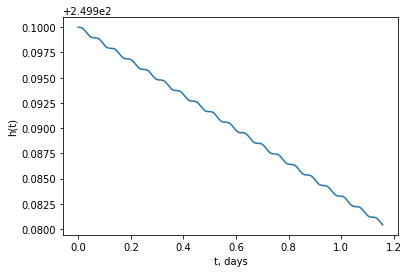

In [4]:
plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs.value, rr.norm() - Earth.R)

### Orbital Decay

If atmospheric drag causes the orbit to fully decay, additional code
is needed to stop the integration when the satellite reaches the
surface.

Please note that you will likely want to use a more sophisticated
atmosphere model than the one in atmospheric_drag for these sorts
of computations.

In [5]:
orbit = Orbit.circular(Earth, 230 * u.km, epoch=Time(0.0, format="jd", scale="tdb"))
tofs = TimeDelta(np.linspace(0 * u.h, 100 * u.d, num=2000))

from poliastro.twobody.events import LithobrakeEvent
lithobrake_event = LithobrakeEvent(R)
events = [lithobrake_event]

rr = propagate(
    orbit,
    tofs,
    method=cowell,
    ad=atmospheric_drag_exponential,
    R=R,
    C_D=C_D,
    A_over_m=A_over_m,
    H0=H0,
    rho0=rho0,
    events=events,
)

print('orbital decay seen after', lithobrake_event.last_t.to(u.d).value, 'days')

orbital decay seen after 48.21793204090946 days


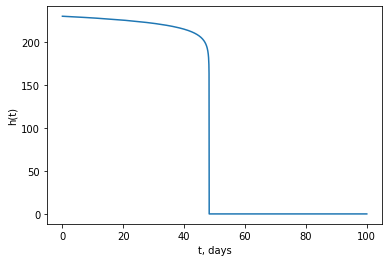

In [6]:
plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs.value, rr.norm() - Earth.R)

### Evolution of RAAN due to the J2 perturbation

We can also see how the J2 perturbation changes RAAN over time!

In [7]:
r0 = np.array([-2384.46, 5729.01, 3050.46]) * u.km
v0 = np.array([-7.36138, -2.98997, 1.64354]) * u.km / u.s

orbit = Orbit.from_vectors(Earth, r0, v0)

tofs = TimeDelta(np.linspace(0, 48.0 * u.h, num=2000))

coords = propagate(
    orbit, tofs, method=cowell,
    ad=J2_perturbation, J2=Earth.J2.value, R=Earth.R.to(u.km).value
)

rr = coords.xyz.T.to(u.km).value
vv = coords.differentials["s"].d_xyz.T.to(u.km / u.s).value

# This will be easier to compute when this is solved:
# https://github.com/poliastro/poliastro/issues/380
raans = [rv2coe(k, r, v)[3] for r, v in zip(rr, vv)]

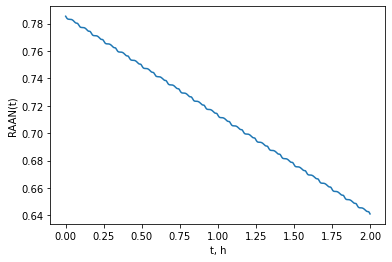

In [8]:
plt.ylabel("RAAN(t)")
plt.xlabel("t, h")
plt.plot(tofs.value, raans)

### 3rd body

Apart from time-independent perturbations such as atmospheric drag, J2/J3, we have time-dependend perturbations. Lets's see how Moon changes the orbit of GEO satellite over time!

In [9]:
# database keeping positions of bodies in Solar system over time
solar_system_ephemeris.set("de432s")

epoch = Time(
    2454283.0, format="jd", scale="tdb"
)  # setting the exact event date is important

# create interpolant of 3rd body coordinates (calling in on every iteration will be just too slow)
body_r = build_ephem_interpolant(
    Moon, 28 * u.day, (epoch.value * u.day, epoch.value * u.day + 60 * u.day), rtol=1e-2
)

initial = Orbit.from_classical(
    Earth,
    42164.0 * u.km,
    0.0001 * u.one,
    1 * u.deg,
    0.0 * u.deg,
    0.0 * u.deg,
    0.0 * u.rad,
    epoch=epoch,
)

tofs = TimeDelta(np.linspace(0, 60 * u.day, num=1000))

# multiply Moon gravity by 400 so that effect is visible :)
rr = propagate(
    initial,
    tofs,
    method=cowell,
    rtol=1e-6,
    ad=third_body,
    k_third=400 * Moon.k.to(u.km ** 3 / u.s ** 2).value,
    perturbation_body=body_r,
)

In [10]:
frame = OrbitPlotter3D()

frame.set_attractor(Earth)
frame.plot_trajectory(rr, label="orbit influenced by Moon")

### Applying thrust

Apart from natural perturbations, there are artificial thrusts aimed at intentional change of orbit parameters. One of such changes is simultaineous change of eccentricity and inclination.

In [11]:
from poliastro.twobody.thrust import change_inc_ecc

ecc_0, ecc_f = 0.4, 0.0
a = 42164  # km
inc_0 = 0.0  # rad, baseline
inc_f = (20.0 * u.deg).to(u.rad).value  # rad
argp = 0.0  # rad, the method is efficient for 0 and 180
f = 2.4e-6  # km / s2

k = Earth.k.to(u.km ** 3 / u.s ** 2).value
s0 = Orbit.from_classical(
    Earth,
    a * u.km,
    ecc_0 * u.one,
    inc_0 * u.deg,
    0 * u.deg,
    argp * u.deg,
    0 * u.deg,
    epoch=Time(0, format="jd", scale="tdb"),
)

a_d, _, _, t_f = change_inc_ecc(s0, ecc_f, inc_f, f)

tofs = TimeDelta(np.linspace(0, t_f * u.s, num=1000))

rr2 = propagate(s0, tofs, method=cowell, rtol=1e-6, ad=a_d)

In [12]:
frame = OrbitPlotter3D()

frame.set_attractor(Earth)
frame.plot_trajectory(rr2, label="orbit with artificial thrust")

### Combining multiple perturbations

It might be of interest to determine what effect multiple perturbations have on a single object. In order to add multiple perturbations we can create a custom function that adds them up:

In [13]:
from poliastro.core.util import jit

# Add @jit for speed!
@jit
def a_d(t0, state, k, J2, R, C_D, A_over_m, H0, rho0):
    return J2_perturbation(t0, state, k, J2, R) + atmospheric_drag_exponential(
        t0, state, k, R, C_D, A_over_m, H0, rho0
    )

In [14]:
# propagation times of flight and orbit
tofs = TimeDelta(np.linspace(0, 10 * u.day, num=10 * 500))
orbit = Orbit.circular(Earth, 250 * u.km)  # recall orbit from drag example

# propagate with J2 and atmospheric drag
rr3 = propagate(
    orbit,
    tofs,
    method=cowell,
    ad=a_d,
    R=R,
    C_D=C_D,
    A_over_m=A_over_m,
    H0=H0,
    rho0=rho0,
    J2=Earth.J2.value,
)

# propagate with only atmospheric drag
rr4 = propagate(
    orbit,
    tofs,
    method=cowell,
    ad=atmospheric_drag_exponential,
    R=R,
    C_D=C_D,
    A_over_m=A_over_m,
    H0=H0,
    rho0=rho0,
)

(225.0, 251.0)

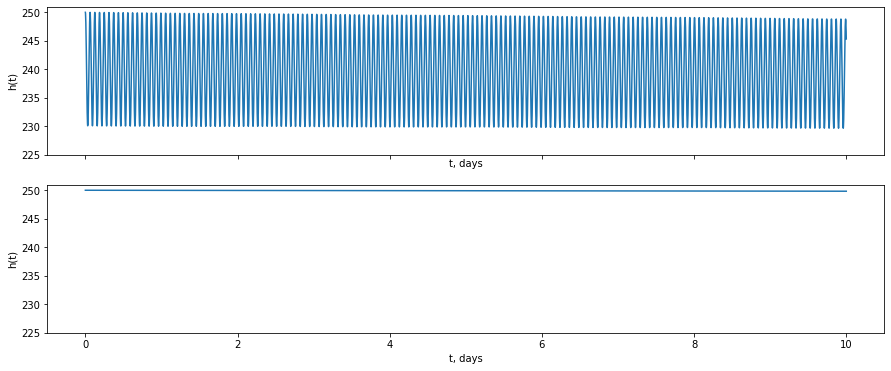

In [15]:
fig, (axes1, axes2) = plt.subplots(nrows=2, sharex=True, figsize=(15, 6))

axes1.plot(tofs.value, rr3.norm() - Earth.R)
axes1.set_ylabel("h(t)")
axes1.set_xlabel("t, days")
axes1.set_ylim([225, 251])

axes2.plot(tofs.value, rr4.norm() - Earth.R)
axes2.set_ylabel("h(t)")
axes2.set_xlabel("t, days")
axes2.set_ylim([225, 251])

The first plot shows the altitude of the orbit changing due to both atmospheric drag and the J2 effect, the second plot shows only the effect of atmospheric drag.